# TODOs
1. ### <s> Lemmatize input - Good
2. ### <s> Replace CNNs with KAN-CNNs - Won't learn, Revisit last
3. ### Prune and test
4. ### <s> B-spline Finetuning - Best with splines = 3
5. ### CNN operates on whole embedded lvl - test on various depths (3, 9, 27, 81)
6. ### Deeper CNN - 1 + 3 + 5 gram feed into Deep CNN -> KAN 
7. ### <s> Data Augmentation
8. ### Limit Vocab Size
9. ### Try Word2Vec or Glove pre-trained

In [1]:
from fastkan import FastKAN as KAN

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

from fastkan import FastKAN as KAN

from tqdm import tqdm
tqdm.pandas()

from sklearn.model_selection import train_test_split

import torchtext
torchtext.disable_torchtext_deprecation_warning()

from torchtext.datasets import IMDB
from transformers import GPT2Tokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kaloq\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kaloq\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kaloq\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
#data = pd.read_csv('./imdb.csv')
#data.head()

train = pd.read_csv("./data/imdb_train_original.csv")
test = pd.read_csv("./data/imdb_test.csv")

In [4]:
# print(train.head)
# print(test.head)

In [5]:
# Convert labels to binary
def transform_label(label):
    return 1 if label == 'positive' else 0

train['label'] = train['sentiment'].progress_apply(transform_label)
test['label'] = test['sentiment'].progress_apply(transform_label)

100%|██████████| 10000/10000 [00:00<00:00, 1246635.16it/s]


In [6]:
# # Check for dataset imbalance
train.sentiment.value_counts()

sentiment
positive    20027
negative    19973
Name: count, dtype: int64

In [7]:
# # Review token length
# train['token_length'] = train.review.progress_apply(lambda x: len(x.split()))
# train.head()

In [8]:
# data_pos = train[train['label'] == 1]
# print("Positive review length")
# data_pos['token_length'].describe()

In [9]:
# data_neg = train[train['label'] == 0]
# print("Negative review length")
# data_neg['token_length'].describe()

In [10]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    
    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)

    # 
    words = word_tokenize(text)
    sent = [word for word in words if word not in stop_words]
    sent = ' '.join(sent)
    
    return sent

In [11]:
# Preprocessing
train['clean'] = train.review.progress_apply(preprocess_text)
test['clean'] = test.review.progress_apply(preprocess_text)

100%|██████████| 10000/10000 [00:04<00:00, 2146.02it/s]


In [12]:
print(train.head())
# print(test.head())

                                              review sentiment  label  \
0  I write this after just seeing the latest epis...  positive      1   
1  Awful movie. It's a shame that a few of Flande...  negative      0   
2  An apt description by Spock of an all-powerful...  positive      1   
3  Presenting Lily Mars (MGM, 1943) is a cute fil...  positive      1   
4  SNL is pretty funny but people who say this is...  negative      0   

                                               clean  
0  write seeing latest episode broadcast uk must ...  
1  awful movie shame flanders top actors actresse...  
2  apt description spock powerful fop whose clutc...  
3  presenting lily mars mgm 1943 cute film opinio...  
4  snl pretty funny people say like watching shor...  


In [13]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [14]:
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    # Tokenize the text if necessary
    words = text.split()
    # Lemmatize each word in the text
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    # Join the lemmatized words back into a string
    lemmatized_text = ' '.join(lemmatized_words)
    return lemmatized_text

In [15]:
train['lemma'] = train['clean'].progress_apply(lemmatize_text)
test['lemma'] = test['clean'].progress_apply(lemmatize_text)

100%|██████████| 10000/10000 [00:02<00:00, 3727.94it/s]


In [16]:
# for n in range(20):
#     print(data['clean'][n])
#     print(data['lemma'][n])

In [17]:
tokenizer.pad_token = tokenizer.eos_token
max_l = 256
#data['tokenized'] = data.lemma.progress_apply(lambda x: tokenizer.encode(text=x, add_special_tokens=False, truncation=True, add_prefix_space=True, padding='max_length', max_length=max_l))
train['tokenized'] = train.lemma.progress_apply(lambda x: tokenizer.encode(text=x, add_special_tokens=False, truncation=True, add_prefix_space=True, padding='max_length', max_length=max_l))
test['tokenized'] = test.lemma.progress_apply(lambda x: tokenizer.encode(text=x, add_special_tokens=False, truncation=True, add_prefix_space=True, padding='max_length', max_length=max_l))

100%|██████████| 10000/10000 [00:05<00:00, 1755.91it/s]


In [18]:
# # Check actual tokenized text len
# data['ct_length'] = data.tokenized.progress_apply(lambda x: len(x))
# data_pos = data[data['label'] == 1]
# data_pos['ct_length'].describe()

In [19]:
# split the data
# X = data.tokenized
# y = data.label
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)
X_train = train.tokenized
y_train = train.label

X_test = test.tokenized
y_test = test.label

# Convert to tensors
X_train_tensor = torch.tensor(X_train.tolist()).to(device)
X_test_tensor = torch.tensor(X_test.tolist()).to(device)
y_train_tensor = torch.tensor(y_train.tolist()).to(device)
y_test_tensor = torch.tensor(y_test.tolist()).to(device)

# Create Datasets - tensors
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [36]:
# Batch the data
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# BEST__SMALL
# Model 89.38% ACC
class CustomCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(CustomCNN, self).__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        # Conv layers with different kernel sizes
        self.conv1 = nn.Conv2d(1, 256, (1, embed_dim), padding=(0, 0))
        self.bn1 = nn.BatchNorm2d(256)
        self.pool1 = nn.MaxPool1d(2)
        self.dropout1 = nn.Dropout(0.25) 
        
        self.conv2 = nn.Conv2d(1, 256, (3, embed_dim), padding=(1, 0))
        self.bn2 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool1d(2)
        self.dropout2 = nn.Dropout(0.25) 
        
        self.conv3 = nn.Conv2d(1, 256, (5, embed_dim), padding=(2, 0))
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool1d(2)
        self.dropout3 = nn.Dropout(0.25) 
        
        # Post PCAT Conv 1
        self.final_conv = nn.Conv2d(3 * 256, 1024, (3, 3), padding=(1, 1))
        
        self.bn_final = nn.BatchNorm2d(1024)
        self.pool_final = nn.MaxPool2d((2, 1))
        self.dropout_pcat1 = nn.Dropout(0.25)

        # Post PCAT Conv 2
        self.conv_pcat2 = nn.Conv2d(1024, 2048, (3, 3), padding=(1, 1))

        self.bn_pcat2 = nn.BatchNorm2d(2048)
        self.pool_pcat2 = nn.MaxPool2d((2, 1))
        self.dropout_pcat2 = nn.Dropout(0.25)

        # Post PCAT Conv 3
        self.conv_pcat3 = nn.Conv2d(2048, 4096, (3, 3), padding=(1, 1))

        self.bn_pcat3 = nn.BatchNorm2d(4096)
        self.pool_pcat3 = nn.MaxPool2d((4, 1))
        self.dropout_pcat3 = nn.Dropout(0.25)
        
        # Replace dense layers with FastKAN
        self.kan_pre = KAN([32768, 256], num_grids=8)
        self.kan = KAN([256, 64, 8, 2], num_grids=8)
        
    def forward(self, x):
        # x shape: (batch_size, seq_len)
        
        # Embedding
        x = self.embedding(x)  # shape: (batch_size, seq_len, embed_dim)
        x = x.unsqueeze(1)  # shape: (batch_size, 1, seq_len, embed_dim)
        
        # Conv layer 1
        x1 = self.conv1(x)  # shape: (batch_size, 100, seq_len-0, 1)
        x1 = self.bn1(x1)
        x1 = F.relu(x1)
        x1 = x1.squeeze(3)  # shape: (batch_size, 100, seq_len-0)
        x1 = self.pool1(x1)  # shape: (batch_size, 100, (seq_len-0)//2)
        x1 = self.dropout1(x1)
        
        # Conv layer 2
        x2 = self.conv2(x)  # shape: (batch_size, 100, seq_len-2, 1)
        x2 = self.bn2(x2)
        x2 = F.relu(x2)
        x2 = x2.squeeze(3)  # shape: (batch_size, 100, seq_len-2)
        x2 = self.pool2(x2)  # shape: (batch_size, 100, (seq_len-2)//2)
        x2 = self.dropout2(x2)
        
        # Conv layer 3
        x3 = self.conv3(x)  # shape: (batch_size, 100, seq_len-4, 1)
        x3 = self.bn3(x3)
        x3 = F.relu(x3)
        x3 = x3.squeeze(3)  # shape: (batch_size, 100, seq_len-4)
        x3 = self.pool3(x3)  # shape: (batch_size, 100, (seq_len-4)//2)
        x3 = self.dropout3(x3) 
        
        # Concatenate along the channel dimension
        x_cat = torch.cat((x1, x2, x3), dim=1)  # shape: (batch_size, 300, ...)
        x_cat = x_cat.unsqueeze(3)  # shape: (batch_size, 300, ..., 1)
        
        # PCAT1 Conv2D layer
        x_out = self.final_conv(x_cat)  # shape: (batch_size, 100, ..., 1)
        x_out = self.bn_final(x_out)
        x_out = F.relu(x_out)
        x_out = self.pool_final(x_out)  # shape: (batch_size, 100, ..., 1)

        x_out = self.dropout_pcat1(x_out)

        # PCAT2 Conv2D layer
        x_out = self.conv_pcat2(x_out)  # shape: (batch_size, 100, ..., 1)
        x_out = self.bn_pcat2(x_out)
        x_out = F.relu(x_out)
        x_out = self.pool_pcat2(x_out)  # shape: (batch_size, 100, ..., 1)

        # PCAT3 Conv2D layer
        x_out = self.conv_pcat3(x_out)  # shape: (batch_size, 100, ..., 1)
        x_out = self.bn_pcat3(x_out)
        x_out = F.relu(x_out)
        x_out = self.pool_pcat3(x_out)  # shape: (batch_size, 100, ..., 1)
        
        # Flatten the tensor for the dense layer
        x_out = x_out.view(x_out.size(0), -1)  # shape: (batch_size, 100)
        x_out = self.dropout_pcat3(x_out)
        
        # Dense layer
        x_out = self.kan_pre(x_out)
        x_out = self.kan(x_out)# shape: (batch_size, num_classes)
        
        return x_out

# Hyperparams
vocab_size = len(tokenizer)  # Vocabulary size of GPT-2 tokenizer
embed_dim = 32  # Embedding dimension
num_class = 2  # Number of classes (negative, positive)

model = CustomCNN(vocab_size, embed_dim)
model.to(device)

CustomCNN(
  (embedding): Embedding(50257, 32)
  (conv1): Conv2d(1, 256, kernel_size=(1, 32), stride=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(1, 256, kernel_size=(3, 32), stride=(1, 1), padding=(1, 0))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(1, 256, kernel_size=(5, 32), stride=(1, 1), padding=(2, 0))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.25, inplace=False)
  (final_conv): Conv2d(768, 1024, kernel_size=(3, 3), stride=(1, 1), pad

In [42]:
#from torchinfo import summary
#summary(model, input_size=(batch_size, max_l), dtypes=([torch.int64]), col_names=["kernel_size", "input_size", "output_size", "num_params"])

In [43]:
# Evaluation function
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
    with torch.no_grad():
        for texts, labels in test_loader:
            outputs = model(texts)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            correct += calculate_accuracy(outputs, labels)
            total += labels.size(0)
    accuracy = correct / total
    avg_loss = total_loss / total
    return accuracy, avg_loss

In [44]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = optim.RAdam(model.parameters(), lr=4e-3, weight_decay=1e-4, decoupled_weight_decay=True)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
#optimizer = optim.AdamW(model.parameters(), lr=8e-4, weight_decay=8e-5)
#optimizer = optim.SparseAdam(model.parameters(), lr=1e-3)

# Learning rate decay
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# Accuracy calculation
def calculate_accuracy(preds, labels):
    _, predicted = torch.max(preds, 1)
    correct = (predicted == labels).sum().item()
    return correct

# Training loop
num_epochs = 40
model_history = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
        for texts, labels in pbar:
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            correct_predictions += calculate_accuracy(outputs, labels)
            total_predictions += labels.size(0)
            
            accuracy = correct_predictions / total_predictions
            
            pbar.set_postfix(loss=total_loss/total_predictions, accuracy=accuracy)
    scheduler.step()

    model_history.append(evaluate(model, test_loader))
    print(f'Epoch {epoch+1}, Loss: {total_loss/(len(train_loader)*batch_size)}, Accuracy: {accuracy}')
    print(f'Val_Loss: {model_history[epoch][1]}, Val_Accuracy: {model_history[epoch][0]}')


Epoch 1/40: 100%|██████████| 1250/1250 [02:14<00:00,  9.29it/s, accuracy=0.502, loss=0.0222]


Epoch 1, Loss: 0.022202707362174987, Accuracy: 0.502225
Val_Loss: 0.021710088032484056, Val_Accuracy: 0.5027


Epoch 2/40: 100%|██████████| 1250/1250 [02:14<00:00,  9.28it/s, accuracy=0.499, loss=0.0217]


Epoch 2, Loss: 0.021686692729592325, Accuracy: 0.499425
Val_Loss: 0.021713240176439285, Val_Accuracy: 0.5027


Epoch 3/40: 100%|██████████| 1250/1250 [02:16<00:00,  9.14it/s, accuracy=0.7, loss=0.0166]  


Epoch 3, Loss: 0.01661953309252858, Accuracy: 0.699775
Val_Loss: 0.010882410110533237, Val_Accuracy: 0.849


Epoch 4/40: 100%|██████████| 1250/1250 [02:14<00:00,  9.29it/s, accuracy=0.882, loss=0.00913]


Epoch 4, Loss: 0.009134930457361043, Accuracy: 0.88215
Val_Loss: 0.009112197609990835, Val_Accuracy: 0.8875


Epoch 5/40: 100%|██████████| 1250/1250 [02:14<00:00,  9.28it/s, accuracy=0.906, loss=0.00764]


Epoch 5, Loss: 0.007638575794361532, Accuracy: 0.905725
Val_Loss: 0.008621584913507103, Val_Accuracy: 0.8909


Epoch 6/40: 100%|██████████| 1250/1250 [02:14<00:00,  9.33it/s, accuracy=0.919, loss=0.00665]


Epoch 6, Loss: 0.00664668576894328, Accuracy: 0.918875
Val_Loss: 0.008240277274698019, Val_Accuracy: 0.8954


Epoch 7/40: 100%|██████████| 1250/1250 [02:16<00:00,  9.19it/s, accuracy=0.933, loss=0.00566]


Epoch 7, Loss: 0.005662965477490798, Accuracy: 0.933175
Val_Loss: 0.008796110573038458, Val_Accuracy: 0.8928


Epoch 8/40: 100%|██████████| 1250/1250 [02:14<00:00,  9.32it/s, accuracy=0.943, loss=0.00503]


Epoch 8, Loss: 0.005032771806186065, Accuracy: 0.94285
Val_Loss: 0.00903471055701375, Val_Accuracy: 0.8938


Epoch 9/40: 100%|██████████| 1250/1250 [02:12<00:00,  9.45it/s, accuracy=0.951, loss=0.00432]


Epoch 9, Loss: 0.004319710858399048, Accuracy: 0.95095
Val_Loss: 0.010208942409045994, Val_Accuracy: 0.8835


Epoch 10/40: 100%|██████████| 1250/1250 [02:12<00:00,  9.41it/s, accuracy=0.957, loss=0.00381]


Epoch 10, Loss: 0.0038108594294404613, Accuracy: 0.956775
Val_Loss: 0.010213008493557572, Val_Accuracy: 0.8875


Epoch 11/40: 100%|██████████| 1250/1250 [02:11<00:00,  9.48it/s, accuracy=0.964, loss=0.00333]


Epoch 11, Loss: 0.0033292586619383655, Accuracy: 0.96425
Val_Loss: 0.010775531477667391, Val_Accuracy: 0.8847


Epoch 12/40: 100%|██████████| 1250/1250 [02:12<00:00,  9.41it/s, accuracy=0.967, loss=0.00301]


Epoch 12, Loss: 0.003012155649275519, Accuracy: 0.96685
Val_Loss: 0.012056928920559585, Val_Accuracy: 0.8827


Epoch 13/40: 100%|██████████| 1250/1250 [02:11<00:00,  9.49it/s, accuracy=0.972, loss=0.00267]


Epoch 13, Loss: 0.0026680968047818167, Accuracy: 0.97225
Val_Loss: 0.01076184882633388, Val_Accuracy: 0.8857


Epoch 14/40: 100%|██████████| 1250/1250 [02:15<00:00,  9.24it/s, accuracy=0.974, loss=0.00235]


Epoch 14, Loss: 0.0023519486108329146, Accuracy: 0.974425
Val_Loss: 0.012836991980485619, Val_Accuracy: 0.8802


Epoch 15/40: 100%|██████████| 1250/1250 [02:14<00:00,  9.32it/s, accuracy=0.979, loss=0.0021] 


Epoch 15, Loss: 0.0020959786775521932, Accuracy: 0.978775
Val_Loss: 0.014094327245932072, Val_Accuracy: 0.8779


Epoch 16/40: 100%|██████████| 1250/1250 [02:14<00:00,  9.30it/s, accuracy=0.983, loss=0.00173]


Epoch 16, Loss: 0.0017326657025943859, Accuracy: 0.9831
Val_Loss: 0.014624160738801583, Val_Accuracy: 0.8705


Epoch 17/40: 100%|██████████| 1250/1250 [02:11<00:00,  9.50it/s, accuracy=0.984, loss=0.00165]


Epoch 17, Loss: 0.0016529686685535126, Accuracy: 0.983775
Val_Loss: 0.013247411374468356, Val_Accuracy: 0.8779


Epoch 18/40: 100%|██████████| 1250/1250 [02:11<00:00,  9.49it/s, accuracy=0.985, loss=0.00156]


Epoch 18, Loss: 0.001557998308131937, Accuracy: 0.98485
Val_Loss: 0.015028643723484128, Val_Accuracy: 0.8763


Epoch 19/40: 100%|██████████| 1250/1250 [02:11<00:00,  9.48it/s, accuracy=0.988, loss=0.0013] 


Epoch 19, Loss: 0.001303161735937465, Accuracy: 0.987875
Val_Loss: 0.015088826815178619, Val_Accuracy: 0.8687


Epoch 20/40: 100%|██████████| 1250/1250 [02:11<00:00,  9.50it/s, accuracy=0.988, loss=0.00125]


Epoch 20, Loss: 0.0012488308931002394, Accuracy: 0.9884
Val_Loss: 0.016163036389742046, Val_Accuracy: 0.8741


Epoch 21/40: 100%|██████████| 1250/1250 [02:11<00:00,  9.50it/s, accuracy=0.991, loss=0.00104]


Epoch 21, Loss: 0.0010439354243688284, Accuracy: 0.990775
Val_Loss: 0.017037593928165735, Val_Accuracy: 0.878


Epoch 22/40: 100%|██████████| 1250/1250 [02:11<00:00,  9.50it/s, accuracy=0.992, loss=0.000988]


Epoch 22, Loss: 0.0009884163664915832, Accuracy: 0.9919
Val_Loss: 0.017206064600357784, Val_Accuracy: 0.8748


Epoch 23/40: 100%|██████████| 1250/1250 [02:11<00:00,  9.50it/s, accuracy=0.992, loss=0.000953]


Epoch 23, Loss: 0.0009529886704898672, Accuracy: 0.991925
Val_Loss: 0.017614401877485215, Val_Accuracy: 0.8753


Epoch 24/40: 100%|██████████| 1250/1250 [02:11<00:00,  9.49it/s, accuracy=0.993, loss=0.000857]


Epoch 24, Loss: 0.0008566465679556132, Accuracy: 0.993325
Val_Loss: 0.018181831430178135, Val_Accuracy: 0.8731


Epoch 25/40: 100%|██████████| 1250/1250 [02:11<00:00,  9.49it/s, accuracy=0.994, loss=0.000765]


Epoch 25, Loss: 0.0007650694613228552, Accuracy: 0.9939
Val_Loss: 0.018208786193118432, Val_Accuracy: 0.8774


Epoch 26/40: 100%|██████████| 1250/1250 [02:11<00:00,  9.49it/s, accuracy=0.995, loss=0.000735]


Epoch 26, Loss: 0.0007354205141949933, Accuracy: 0.994525
Val_Loss: 0.018796238084114156, Val_Accuracy: 0.8707


Epoch 27/40: 100%|██████████| 1250/1250 [02:11<00:00,  9.49it/s, accuracy=0.994, loss=0.000733]


Epoch 27, Loss: 0.0007326353709737305, Accuracy: 0.99435
Val_Loss: 0.018868394510867074, Val_Accuracy: 0.8731


Epoch 28/40: 100%|██████████| 1250/1250 [02:11<00:00,  9.49it/s, accuracy=0.995, loss=0.0007]  


Epoch 28, Loss: 0.0007003649840102298, Accuracy: 0.994525
Val_Loss: 0.019045651621813885, Val_Accuracy: 0.873


Epoch 29/40: 100%|██████████| 1250/1250 [02:11<00:00,  9.50it/s, accuracy=0.996, loss=0.000621]


Epoch 29, Loss: 0.0006210755352367414, Accuracy: 0.995625
Val_Loss: 0.018852081119059585, Val_Accuracy: 0.8729


Epoch 30/40: 100%|██████████| 1250/1250 [02:11<00:00,  9.50it/s, accuracy=0.996, loss=0.000615]


Epoch 30, Loss: 0.0006145184725872241, Accuracy: 0.995575
Val_Loss: 0.019164091898011975, Val_Accuracy: 0.871


Epoch 31/40: 100%|██████████| 1250/1250 [02:11<00:00,  9.48it/s, accuracy=0.996, loss=0.00058] 


Epoch 31, Loss: 0.0005795276637974893, Accuracy: 0.996225
Val_Loss: 0.01952206326615997, Val_Accuracy: 0.8694


Epoch 32/40: 100%|██████████| 1250/1250 [02:11<00:00,  9.50it/s, accuracy=0.997, loss=0.000529]


Epoch 32, Loss: 0.0005286469451704761, Accuracy: 0.996525
Val_Loss: 0.020183218062086963, Val_Accuracy: 0.8681


Epoch 33/40: 100%|██████████| 1250/1250 [02:11<00:00,  9.49it/s, accuracy=0.996, loss=0.000572]


Epoch 33, Loss: 0.0005724124993663281, Accuracy: 0.9959
Val_Loss: 0.02067401655788999, Val_Accuracy: 0.8723


Epoch 34/40: 100%|██████████| 1250/1250 [02:11<00:00,  9.49it/s, accuracy=0.997, loss=0.000528]


Epoch 34, Loss: 0.0005284045043983497, Accuracy: 0.99655
Val_Loss: 0.019561111296527087, Val_Accuracy: 0.8679


Epoch 35/40: 100%|██████████| 1250/1250 [02:11<00:00,  9.48it/s, accuracy=0.996, loss=0.000546]


Epoch 35, Loss: 0.0005463039625406964, Accuracy: 0.99625
Val_Loss: 0.020178848391585052, Val_Accuracy: 0.8731


Epoch 36/40: 100%|██████████| 1250/1250 [02:14<00:00,  9.31it/s, accuracy=0.997, loss=0.000497]


Epoch 36, Loss: 0.0004968643419619184, Accuracy: 0.99695
Val_Loss: 0.02065384179347893, Val_Accuracy: 0.8741


Epoch 37/40: 100%|██████████| 1250/1250 [02:12<00:00,  9.45it/s, accuracy=0.997, loss=0.000495]


Epoch 37, Loss: 0.0004953088279988151, Accuracy: 0.996975
Val_Loss: 0.021159897419076878, Val_Accuracy: 0.8721


Epoch 38/40: 100%|██████████| 1250/1250 [02:13<00:00,  9.37it/s, accuracy=0.997, loss=0.00049] 


Epoch 38, Loss: 0.0004900853376631857, Accuracy: 0.9969
Val_Loss: 0.020718892691563816, Val_Accuracy: 0.872


Epoch 39/40: 100%|██████████| 1250/1250 [02:12<00:00,  9.45it/s, accuracy=0.997, loss=0.000474]


Epoch 39, Loss: 0.0004738539703539573, Accuracy: 0.99715
Val_Loss: 0.020394099683407694, Val_Accuracy: 0.8729


Epoch 40/40: 100%|██████████| 1250/1250 [02:14<00:00,  9.30it/s, accuracy=0.997, loss=0.000465]


Epoch 40, Loss: 0.0004654527347622206, Accuracy: 0.99725
Val_Loss: 0.02037794474370312, Val_Accuracy: 0.8714


In [56]:
from torchviz import make_dot
import torch
import os
import sys
# Example input
x = torch.randint(0, vocab_size, (batch_size, max_l)).to(device)  # Example of random integer indices
x = x.long()  # Ensure it's a LongTensor

# Forward pass
y = model(x)

# Visualize the computation graph
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
make_dot(y, params=dict(model.named_parameters())).render("model", format="png")

'model.png'

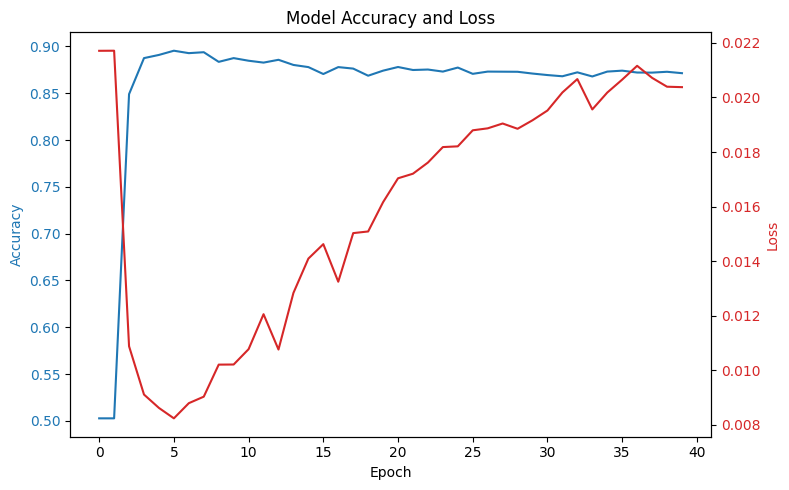

In [45]:
import matplotlib.pyplot as plt

#Plot val acc and loss
accuracy = [entry[0] for entry in model_history]
loss = [entry[1] for entry in model_history]

fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot accuracy on primary y
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color='tab:blue')
ax1.plot(accuracy, label='Accuracy', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Plot the loss on secondary y
ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='tab:red')
ax2.plot(loss, label='Loss', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Model Accuracy and Loss')
fig.tight_layout()
plt.show()

In [32]:
torch.save(model, './model_saves/model_complete.pth')

In [33]:
del model

In [34]:
import gc         # garbage collect library
gc.collect()
torch.cuda.empty_cache() 

In [35]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [27]:
from numba import cuda
 
cuda.select_device(0) # choosing second GPU 
cuda.close()

In [36]:
device = cuda.get_current_device()
device.reset()
cuda.close()
print(device)

<CUDA device 0 'b'NVIDIA GeForce RTX 3080 Laptop GPU''>
